# Цель Блокнота

Решение задачи регрессии в scikit-learn с помощью бустингов
* Создание класса *TargetEncoder* для кодирования категориальных признаков
* Обучение класса `AdaBoostRegressor`
* Обучение класса `GradientBoostingRegressor`
* Обучение класса `HistGradientBoostingRegressor`
* Сохранение модели

# Import библиотек

In [ ]:
import pandas as pd # Библиотека Pandas для работы с табличными данными
import numpy as np # библиотека Numpy для операций линейной алгебры и прочего
import matplotlib.pyplot as plt # библиотека Matplotlib для визуализации
import seaborn as sns # библиотека seaborn для визуализации
import numpy as np # библиотека Numpy для операций линейной алгебры и прочего


# предварительная обработка числовых признаков
from sklearn.preprocessing import MinMaxScaler # Импортируем нормализацию от scikit-learn
from sklearn.preprocessing import StandardScaler # Импортируем стандартизацию от scikit-learn
from sklearn.preprocessing import PowerTransformer  # Степенное преобразование от scikit-learn
# предварительная обработка категориальных признаков
from sklearn.preprocessing import OneHotEncoder # Импортируем One-Hot Encoding от scikit-learn
from sklearn.preprocessing import OrdinalEncoder # Импортируем порядковое кодированиеот scikit-learn

from sklearn.pipeline import Pipeline # Pipeline. Ни добавить, ни убавить

from sklearn.compose import ColumnTransformer # т.н. преобразователь колонок

from sklearn.base import BaseEstimator, TransformerMixin # для создания собственных преобразователей / трансформеров данных

In [ ]:
plt.style.use('dark_background') # для модных черных рисунков

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Набор данных



Набор данных представляет собой статистику признаков автомобилей на вторичном рынке в Молдавии.

Набор включает ряд категориальных и численных значений, составляющих одну запись (строку). Число записей можно найти как число строк.

Каждый столбец в записи — это отдельный признак.

Среди указанных признаков приведен целевой для задачи предсказания (регрессии) - цена автомобиля.

 Также среди признак есть целевой для задачи классификации - тип трансмиссии.

 Последняя задача может быть рассмотрена, например, как пример задачи на заполнение пропусков (если продавец не указал соответствующий признак).

# Загрузка данных

Загружаем наши данные из файла по прямой ссылке на GitHub

In [ ]:
DF = pd.read_csv('https://raw.githubusercontent.com/dayekb/mpti_ml/main/data/cars_moldova_no_dup_no_outliers.csv', delimiter = ',')
DF

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro)
0,Toyota,Prius,2011,Hatchback,195000.0,1800.0,Hybrid,Automatic,7750.0
1,Renault,Grand Scenic,2014,Universal,135000.0,1500.0,Diesel,Manual,8550.0
2,Renault,Laguna,2012,Universal,110000.0,1500.0,Diesel,Manual,6550.0
3,Opel,Astra,2006,Universal,200000.0,1600.0,Metan/Propan,Manual,4100.0
4,Mercedes,Vito,2000,Microvan,300000.0,2200.0,Diesel,Manual,3490.0
...,...,...,...,...,...,...,...,...,...
32480,Volkswagen,Passat,2016,Sedan,88000.0,1800.0,Petrol,Automatic,11500.0
32481,Land Rover,Freelander,2002,Crossover,225000.0,1800.0,Metan/Propan,Manual,4400.0
32482,Dacia,Logan Mcv,2015,Universal,89000.0,1500.0,Diesel,Manual,7000.0
32483,Mazda,6,2006,Combi,370000.0,2000.0,Diesel,Manual,4000.0


Список числовых и категориальных данных

In [ ]:
cat_columns = ['Make', 'Model', 'Style', 'Fuel_type', 'Transmission']
num_columns = ['Year', 'Distance', 'Engine_capacity(cm3)', 'Price(euro)']

Предварительная обработка в основном из [раннего блокнота](https://colab.research.google.com/drive/1es_OrShFiuaeOnlPjX2B1geHDM-XfofM?usp=sharing)

Из предварительной обработки исключена колонка `Price(euro)`, поскольку она является целевой меткой и будет обработана отдельно

Также для числовых признаков убрано масштабирование (посколько деревья решений могут обходиться и без них без потери качества)

Вместо one-hot кодирования предлагается простая реализация `TargetEncoder`, которая заменяет категориальный признак на среднее значение целевой переменной по категории. Это позволяет "осознанно" использовать категории в деревьях решений без "разрастания" признаков до большого числа (как в случае применения one-hot кодирования)

In [ ]:
class QuantileReplacer(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.05):
        self.threshold = threshold
        self.quantiles = {}

    def fit(self, X, y=None):
        for col in X.select_dtypes(include='number'):
            low_quantile = X[col].quantile(self.threshold)
            high_quantile = X[col].quantile(1 - self.threshold)
            self.quantiles[col] = (low_quantile, high_quantile)
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in X.select_dtypes(include='number'):
            low_quantile, high_quantile = self.quantiles[col]
            rare_mask = ((X[col] < low_quantile) | (X[col] > high_quantile))
            if rare_mask.any():
                rare_values = X_copy.loc[rare_mask, col]
                replace_value = np.mean([low_quantile, high_quantile])
                if rare_values.mean() > replace_value:
                    X_copy.loc[rare_mask, col] = high_quantile
                else:
                    X_copy.loc[rare_mask, col] = low_quantile
        return X_copy

In [ ]:
class RareGrouper(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.05, other_value='Other'):
        self.threshold = threshold
        self.other_value = other_value
        self.freq_dict = {}

    def fit(self, X, y=None):
        for col in X.select_dtypes(include=['object']):
            freq = X[col].value_counts(normalize=True)
            self.freq_dict[col] = freq[freq >= self.threshold].index.tolist()
        return self

    def transform(self, X, y=None):
        X_copy = X.copy()
        for col in X.select_dtypes(include=['object']):
            X_copy[col] = X_copy[col].apply(lambda x: x if x in self.freq_dict[col] else self.other_value)
        return X_copy

Класс `TargetEncoder` принимает необязательный параметр `cols`, который представляет собой список столбцов для кодирования. Если `cols` не указан, он будет кодировать все категориальные столбцы во фрейме данных.

Метод `fit` вычисляет среднее целевое значение для каждого уникального значения в указанных столбцах. Затем он сохраняет средние целевые значения в словаре.

Метод `transform` использует средние целевые значения, хранящиеся в словаре, для замены категориальных значений их соответствующими средними целевыми значениями. Если категориальное значение не найдено в словаре, оно заменяется средним значением столбца.

In [ ]:
class TargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cols=None):
        self.cols = cols
        self.target_mean = {}

    def fit(self, X, y):
        if self.cols is None:
            self.cols = X.columns
        for col in self.cols:
            self.target_mean[col] = {}
            X_copy = X.copy()
            X_copy[y.name]=y
            self.target_mean[col] = X_copy.groupby(col)[y.name].mean().to_dict()
        return self

    def transform(self, X):
        for col in self.cols:
            X[col] = X[col].map(self.target_mean[col])
            X[col] = X[col].fillna(np.mean(X[col]))
        return X

In [ ]:
num_pipe_distance = Pipeline([
    ('QuantReplace', QuantileReplacer(threshold=0.01, )),
    ('scaler', None)
])

num_distance = ['Distance']

num_pipe_engine = Pipeline([
    ('scaler', None)
])

num_engine = ['Engine_capacity(cm3)']

num_pipe_year = Pipeline([
    ('QuantReplace', QuantileReplacer(threshold=0.01, )),
    ('power', None)
])

num_year = ['Year']

cat_pipe_transmission = Pipeline([
    ('encoder', OrdinalEncoder())

])

cat_transmission = ['Transmission']

cat_pipe_style_fuel = Pipeline([
    ('encoder', TargetEncoder())

])

cat_style_fuel = ['Style', 'Fuel_type']

cat_pipe_make = Pipeline([
    ('replace_rare', RareGrouper(threshold=0.001, other_value='Other')),
    ('encoder', TargetEncoder())
])

cat_make = ['Make']

cat_pipe_model = Pipeline([
    ('replace_rare', RareGrouper(threshold=0.0001, other_value='Other')),
    ('encoder', TargetEncoder())
])

cat_model = ['Model']

preprocessors_all = ColumnTransformer(transformers=[
    ('num_distance', num_pipe_distance, num_distance),
    ('num_engine', num_pipe_engine, num_engine),
    ('num_year', num_pipe_year, num_year),
    ('cat_transmission', cat_pipe_transmission, cat_transmission),
    ('cat_style_fuel', cat_pipe_style_fuel, cat_style_fuel),
    ('cat_make', cat_pipe_make, cat_make),
    ('cat_model', cat_pipe_model, cat_model),
])

# Адаптивный Бустинг для Регрессии

In [ ]:
from sklearn.ensemble import AdaBoostRegressor # Адаптивный Бустинг для Регрессии от scikit-learn

from sklearn.model_selection import train_test_split # функция разбиения на тренировочную и валидационную выборку
# в исполнении scikit-learn
from sklearn.model_selection import ShuffleSplit # при кросс-валидации случайно перемешиваем данные
from sklearn.model_selection import cross_validate # функция кросс-валидации от Scikit-learn

from sklearn.metrics import mean_squared_error as mse # метрика MSE от Scikit-learn
from sklearn.metrics import r2_score # коэффициент детерминации  от Scikit-learn

from sklearn.metrics import PredictionErrorDisplay # Класс визуализации ошибок модели

**Считываем данные, разбиваем на тренировочную и валидационную**

In [ ]:
# не забываем удалить целевую переменную цену из признаков
X, y = DF.drop(columns = ['Price(euro)']), DF['Price(euro)']

# разбиваем на тренировочную и валидационную
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=42)

## Сразу используем все признаки

**Преобразуем данные**

Поскольку мы используем TargetEncoder для обучения, необходимо использовать столбец целевой переменной

In [ ]:
# Сначала обучаем на тренировочных данных, при этом одновременно трансформируем их
X_train_prep = preprocessors_all.fit_transform(X_train, y_train)
# потом трансформируем на валидационных данных
X_val_prep = preprocessors_all.transform(X_val)

In [ ]:
# объединяем названия колонок в один список (важен порядок как в ColumnTransformer)
columns = np.hstack([num_distance,
                    num_engine,
                    num_year,
                    cat_transmission,
                    cat_style_fuel,
                    cat_make,
                    cat_model])

**Обучаем модель**



Стандартная уже для нас рутина

* Создаем объект класса, в котором можем изменить
    * `estimator` - базовое решение, которое используется в модели (по умолчанию - дерево решений глубиной 3)
    * `n_estimators` - максимальное количество итераций (по умолчанию 50)
    * `learning_rate` - с каким коэффициентом мы добавляем новые решения
    * `loss` - функция потерь для оценки ошибок для обновления весов, на выбор `'linear', 'square', 'exponential'`
    * `random_state` - для повторяемости
* "Обучаем" через метод `.fit`

In [ ]:
model_ab = AdaBoostRegressor(learning_rate=0.1,
                        n_estimators=50,
                             loss = 'exponential',
                             random_state = 42
                              )

model_ab.fit(X_train_prep, y_train)

AdaBoostRegressor(learning_rate=0.1, loss='exponential', random_state=42)

Для косвенной оценки "хватит ли итераций или нет" можно посмотреть веса

Если появляются нули - значит модель скорее всего "лучше уже не придумает""

In [ ]:
model_ab.estimator_weights_

array([0.2722026 , 0.27169925, 0.26890013, 0.26391177, 0.26241406,
       0.25706773, 0.25251648, 0.25891631, 0.25620181, 0.25036099,
       0.24708474, 0.24341456, 0.24645323, 0.23844703, 0.23636542,
       0.23488869, 0.23027524, 0.23277668, 0.22848523, 0.22556003,
       0.22277048, 0.22393145, 0.21983037, 0.21374398, 0.21402464,
       0.20818705, 0.20870558, 0.20930351, 0.20083698, 0.19626007,
       0.19586126, 0.19132215, 0.19214426, 0.18673253, 0.18372635,
       0.17397189, 0.17353513, 0.17597613, 0.17135164, 0.16732767,
       0.16345211, 0.16261711, 0.15813336, 0.15975739, 0.15432569,
       0.15512989, 0.15329317, 0.14742922, 0.14691129, 0.14388621])

Ошибки отдельных предсказателей

In [ ]:
model_ab.estimator_errors_

array([0.0616861 , 0.06197808, 0.06362549, 0.06666291, 0.06760084,
       0.07104959, 0.07411275, 0.06983913, 0.07162324, 0.0756055 ,
       0.07792732, 0.08060571, 0.07838231, 0.0843646 , 0.08598656,
       0.08715429, 0.09089526, 0.08884928, 0.09238528, 0.09486749,
       0.09729003, 0.09627517, 0.09990292, 0.10551078, 0.10524618,
       0.11087144, 0.11036131, 0.10977562, 0.11832694, 0.12318586,
       0.12361727, 0.12861936, 0.12770078, 0.13385151, 0.13737525,
       0.14934864, 0.14990437, 0.14682024, 0.15270817, 0.1579878 ,
       0.16321195, 0.16435555, 0.17060669, 0.16832098, 0.17606231,
       0.17489874, 0.17756515, 0.1862911 , 0.18707749, 0.19172161])

Отдельные предсказатели (для повторяемости)

In [ ]:
model_ab.estimators_

[DecisionTreeRegressor(max_depth=3, random_state=1608637542),
 DecisionTreeRegressor(max_depth=3, random_state=2136567244),
 DecisionTreeRegressor(max_depth=3, random_state=1628700026),
 DecisionTreeRegressor(max_depth=3, random_state=22750613),
 DecisionTreeRegressor(max_depth=3, random_state=1486421367),
 DecisionTreeRegressor(max_depth=3, random_state=1448939255),
 DecisionTreeRegressor(max_depth=3, random_state=1146089652),
 DecisionTreeRegressor(max_depth=3, random_state=527608858),
 DecisionTreeRegressor(max_depth=3, random_state=1157948361),
 DecisionTreeRegressor(max_depth=3, random_state=1901857501),
 DecisionTreeRegressor(max_depth=3, random_state=217999646),
 DecisionTreeRegressor(max_depth=3, random_state=1090945134),
 DecisionTreeRegressor(max_depth=3, random_state=297027447),
 DecisionTreeRegressor(max_depth=3, random_state=1064029002),
 DecisionTreeRegressor(max_depth=3, random_state=578495151),
 DecisionTreeRegressor(max_depth=3, random_state=589374304),
 DecisionTreeRe

## Визуализация значимости признаков

In [ ]:
def feature_importance_plotter(model, features_names):
    """Отрисовка значимости признаков в виде горизонтальных столбчатых диаграмм.
    Параметры:
    ===========
    model: модель
    features_names: список имен признаков
    """
    feature_importance = model.feature_importances_

    sorted = np.argsort(feature_importance)

    ypos = np.arange(len(features_names))

    fig= plt.figure(figsize=(8,4))
    plt.barh(ypos, feature_importance[sorted])
    plt.xlim([0,1])
    plt.ylabel('Параметры')
    plt.xlabel('Значимость')
    plt.yticks(ypos,features_names[sorted] );

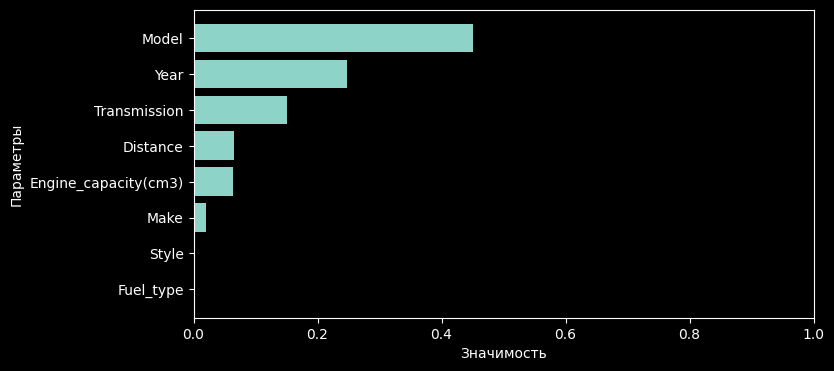

In [ ]:
feature_importance_plotter(model_ab, columns)

## Оценка метрик

In [ ]:
def calculate_metric(model_pipe, X, y, metric = r2_score):
    """Расчет метрики.
    Параметры:
    ===========
    model_pipe: модель или pipeline
    X: признаки
    y: истинные значения
    metric: метрика (r2 - по умолчанию)
    """
    y_model = model_pipe.predict(X)
    return metric(y, y_model)

In [ ]:
print(f"r2 на тренировочной выборке: {calculate_metric(model_ab, X_train_prep, y_train):.4f}")
print(f"r2 на валидационной выборке: {calculate_metric(model_ab, X_val_prep, y_val):.4f}")

print(f"mse на тренировочной выборке: {calculate_metric(model_ab, X_train_prep, y_train, mse):.4f}")
print(f"mse на валидационной выборке: {calculate_metric(model_ab, X_val_prep, y_val, mse):.4f}")

r2 на тренировочной выборке: 0.6986
r2 на валидационной выборке: 0.6996
mse на тренировочной выборке: 18330081.3076
mse на валидационной выборке: 18913538.3468


## Кросс-валидация

In [ ]:
def cross_validation (X, y, model, scoring, cv_rule):
    """Расчет метрик на кросс-валидации.
    Параметры:
    ===========
    model: модель или pipeline
    X: признаки
    y: истинные значения
    scoring: словарь метрик
    cv_rule: правило кросс-валидации
    """
    scores = cross_validate(model,X, y,
                      scoring=scoring, cv=cv_rule )
    print('Ошибка на кросс-валидации')
    DF_score = pd.DataFrame(scores)
    display(DF_score)
    print('\n')
    print(DF_score.mean()[2:])

In [ ]:
scoring_reg = {'R2': 'r2',
           '-MSE': 'neg_mean_squared_error',
           '-MAE': 'neg_mean_absolute_error',
           '-Max': 'max_error'}

In [ ]:
cross_validation (X_train_prep, y_train,
                  model_ab,
                  scoring_reg,
                  ShuffleSplit(n_splits=5, random_state = 42))

Ошибка на кросс-валидации


,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_-Max
0,3.780842,0.034533,0.679018,-1.900593e+07,-3127.315350,-31369.404219
1,3.343803,0.027382,0.705934,-1.901325e+07,-3106.018321,-29898.319405
2,3.657450,0.027848,0.688422,-1.912853e+07,-3029.820120,-37524.881553
3,5.343207,0.023215,0.694820,-1.822697e+07,-3065.269254,-28203.580666
4,2.318406,0.021637,0.674827,-1.904364e+07,-3023.823805,-40287.193931




test_R2      6.886042e-01
test_-MSE   -1.888366e+07
test_-MAE   -3.070449e+03
test_-Max   -3.345668e+04
dtype: float64


## Визуализация ошибок от scikit-learn

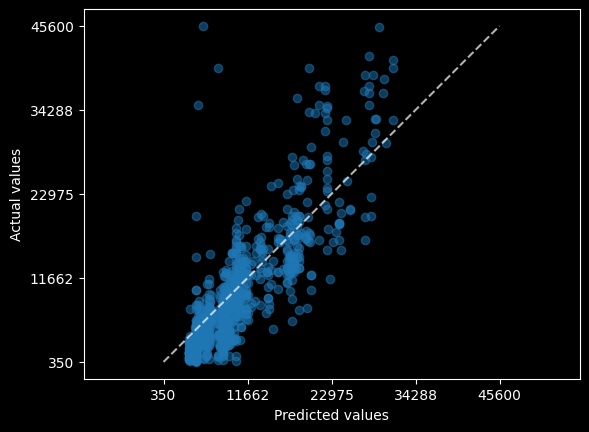

In [ ]:
PredictionErrorDisplay.from_predictions(
    y_val,
    model_ab.predict(X_val_prep),
    kind="actual_vs_predicted",
    scatter_kwargs={"alpha": 0.5},
        line_kwargs = {"color" : 'white'}

);

Небольшие выводы

* Модель адаптивного бустинга на данных гипер-параметрах не очень справляется с предсказанием целевой переменной (метрика r2 на кросс-валидации `0.69` против `0.65` у линейной регрессии, `0.74` у ближайших соседей и `0.75` у простых деревьев решений)

* Значимость признаков в целом напоминает результаты на одиночных деревьях: год и модель так и остались самыми значимыми, подросла значимость объема типа трансмиссии, значимость остальных признаков гораздо ниже



# Градиентный Бустинг для Регрессии

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor # Градиентный Бустинг для Регрессии от scikit-learn
# есть еще якобы ускоренный вариант
from sklearn.ensemble import HistGradientBoostingRegressor

**Обучаем модель**



Стандартная уже для нас рутина

* Создаем объект класса, в котором можем изменить
    * `n_estimators` - максимальное количество итераций (по умолчанию 100)
    * `learning_rate` - с каким коэффициентом мы добавляем новые решения
    * `loss` - функция потерь для оценки ошибок для обновления весов, на выбор `'squared_error', 'absolute_error', 'huber', 'quantile'`
    * `subsample` - какую долю от всей выборки используем для обучения отдельного решения
    * `n_iter_no_change` - чтобы раньше остановиться
    * `random_state` - для повторяемости
    * при этом еще можно прописать детальней архитектуру базовых деревьев (глубина, про листья и т.д.)
* "Обучаем" через метод `.fit`

In [ ]:
model_gb = GradientBoostingRegressor(n_iter_no_change=10,
                                     tol=0.01,
                                learning_rate=0.1,
                                n_estimators=150,
                                subsample = 0.7
                              )

model_gb.fit(X_train_prep, y_train)

GradientBoostingRegressor(n_estimators=150, n_iter_no_change=10, subsample=0.7,
                          tol=0.01)

Ошибки отдельного предсказателя

In [ ]:
model_gb.train_score_

array([53239048.63426544, 48272355.05467416, 42616062.8292625 ,
       39350615.11589245, 36121380.39759937, 32151826.33953699,
       28774854.62723344, 26780821.03144661, 25571599.54029271,
       23458993.45632515, 21875634.64233971, 20984924.10084881,
       19929149.33880806, 19461343.64590913, 18194479.79195765,
       17745025.60761798, 16863506.58349727, 16153969.52886031,
       16068470.64398099, 15141216.90298071, 14680568.95579613,
       14538001.50212817, 13605363.38521182, 13830849.24985234,
       13262004.04887075, 13306214.21055435, 13059212.63033679,
       12824147.70284713, 12423349.94723419, 12616518.83640876,
       13049372.63256313, 11883633.33200049, 12523541.69216217,
       12307335.26849725, 12127727.12050906, 12166627.11379026,
       11962752.60337755, 11855981.2801234 , 11954503.92209674,
       11080903.22146446, 11862644.62978324, 11540891.15526738,
       11133339.9550568 , 11510292.70261336, 11380050.36753835,
       11338011.07073027, 11346029.93746

Отдельные предсказатели тоже можно посмотреть

In [ ]:
model_gb.estimators_

array([[DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                              random_state=RandomState(MT19937) at 0x7DB2BF98D940)],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                              random_state=RandomState(MT19937) at 0x7DB2BF98D940)],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                              random_state=RandomState(MT19937) at 0x7DB2BF98D940)],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                              random_state=RandomState(MT19937) at 0x7DB2BF98D940)],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                              random_state=RandomState(MT19937) at 0x7DB2BF98D940)],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                              random_state=RandomState(MT19937) at 0x7DB2BF98D940)],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
       

## Визуализация значимости признаков

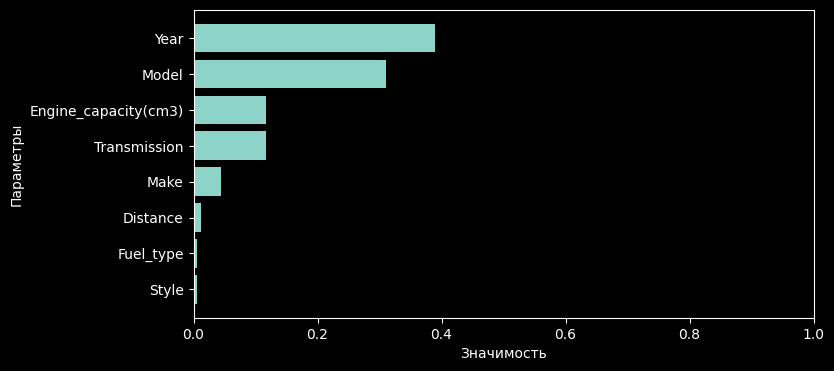

In [ ]:
feature_importance_plotter(model_gb, columns)

## Оценка метрик

In [ ]:
print(f"r2 на тренировочной выборке: {calculate_metric(model_gb, X_train_prep, y_train):.4f}")
print(f"r2 на валидационной выборке: {calculate_metric(model_gb, X_val_prep, y_val):.4f}")

print(f"mse на тренировочной выборке: {calculate_metric(model_gb, X_train_prep, y_train, mse):.4f}")
print(f"mse на валидационной выборке: {calculate_metric(model_gb, X_val_prep, y_val, mse):.4f}")

r2 на тренировочной выборке: 0.8465
r2 на валидационной выборке: 0.8380
mse на тренировочной выборке: 9334519.5216
mse на валидационной выборке: 10199487.0110


## Кросс-валидация

In [ ]:
scoring_reg = {'R2': 'r2',
           '-MSE': 'neg_mean_squared_error',
           '-MAE': 'neg_mean_absolute_error',
           '-Max': 'max_error'}

In [ ]:
cross_validation (X_train_prep, y_train,
                  model_gb,
                  scoring_reg,
                  ShuffleSplit(n_splits=5, random_state = 42))

Ошибка на кросс-валидации


,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_-Max
0,6.973362,0.010083,0.847590,-9.024459e+06,-1853.977545,-25445.994223
1,3.364025,0.010325,0.843744,-1.010296e+07,-1880.006733,-40051.203577
2,3.176067,0.009961,0.827890,-1.056628e+07,-1897.362465,-39700.475465
3,3.342645,0.009879,0.841368,-9.474343e+06,-1926.497405,-20014.700847
4,3.387871,0.009934,0.823613,-1.033003e+07,-1881.607237,-41227.560238




test_R2      8.368409e-01
test_-MSE   -9.899615e+06
test_-MAE   -1.887890e+03
test_-Max   -3.328799e+04
dtype: float64


## Визуализация ошибок от scikit-learn

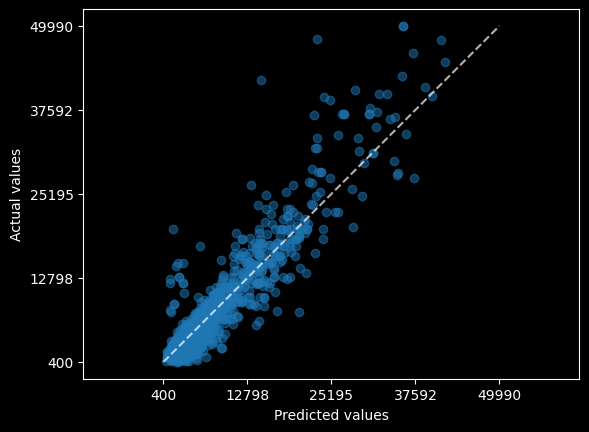

In [ ]:
PredictionErrorDisplay.from_predictions(
    y_val,
    model_gb.predict(X_val_prep),
    kind="actual_vs_predicted",
    scatter_kwargs={"alpha": 0.5},
        line_kwargs = {"color" : 'white'}

);

Небольшие выводы

* Модель градиентного бустинга на этих данных справилась примерно как случайный лес с предсказанием целевой переменной (метрика r2 на кросс-валидации `0.84` против `0.86`)

* Значимость признаков в целом повторяет результаты на одиночных деревьях: год и модель так и остались самыми значимыми, подросла значимость объема двигателя, значимость остальных признаков гораздо ниже

* но тут гиперпараметры в среднем больше влияют



## Посмотрим второй бустинг

**Обучаем модель**



Стандартная уже для нас рутина

* Создаем объект класса, в котором можем изменить
    * `max_iter` - максимальное количество итераций (по умолчанию 100)
    * `learning_rate` - с каким коэффициентом мы добавляем новые решения
    * `loss` - функция потерь для оценки ошибок для обновления весов, на выбор `'squared_error', 'absolute_error', 'gamma', 'poisson', 'quantile'`
    * `categorical_features` - какие признаки являются категориальными (в теории они сами "что-то там делают")
    * `n_iter_no_change` - чтобы раньше остановиться
    * `random_state` - для повторяемости
    * при этом еще можно прописать детальней архитектуру базовых деревьев (глубина, про листья и т.д.)
* "Обучаем" через метод `.fit`

In [ ]:
model_hgb = HistGradientBoostingRegressor(n_iter_no_change=10,
                                learning_rate=0.1,
                                max_iter=150,
                                          )

model_hgb.fit(X_train_prep, y_train)

HistGradientBoostingRegressor(max_iter=150)

Ошибки отдельного предсказателя

In [ ]:
model_hgb.train_score_

array([-30442219.43359443, -25997782.23020602, -22380238.31497565,
       -19360950.96654314, -16865157.57333064, -14806217.62053277,
       -13110496.30637554, -11699095.76353211, -10545140.1588718 ,
        -9564595.03222421,  -8764954.77062658,  -8085294.5906563 ,
        -7516964.24789551,  -7054119.88361092,  -6660182.54367932,
        -6319944.6700045 ,  -6021188.58439134,  -5782912.06574931,
        -5567181.61546647,  -5393613.3436466 ,  -5236041.03892744,
        -5093167.01708827,  -4969627.33424892,  -4861817.26764421,
        -4768496.91249247,  -4683049.66959315,  -4606383.94405827,
        -4539739.9919893 ,  -4483823.28797668,  -4423270.06884107,
        -4368458.55591684,  -4323125.65516457,  -4280690.74603022,
        -4241405.92344463,  -4207513.64126619,  -4172087.12839127,
        -4136947.10819346,  -4102091.73775592,  -4072501.45267671,
        -4044939.8840689 ,  -4018908.76392648,  -3989774.12670468,
        -3959137.60394947,  -3934810.02306365,  -3909557.78733

In [ ]:
model_hgb.validation_score_

array([-30061147.08653028, -25643387.17352418, -22108231.23525347,
       -19210801.50615614, -16801981.13535522, -14874908.22986273,
       -13239847.59271955, -11891047.60253142, -10800415.9813521 ,
        -9876891.82291864,  -9116373.79303616,  -8489529.17949167,
        -7949289.61592857,  -7514686.81013942,  -7111414.76263131,
        -6833442.17850613,  -6564273.95626321,  -6364423.10631714,
        -6153671.13692322,  -5994865.3953717 ,  -5853229.38096379,
        -5733713.54793928,  -5642290.99322296,  -5560153.21884994,
        -5514131.5007107 ,  -5437932.17920453,  -5396523.57423948,
        -5339508.51723216,  -5308836.538057  ,  -5258977.39281407,
        -5227719.02814009,  -5189844.7954025 ,  -5148016.00876668,
        -5119439.97374723,  -5101037.57044524,  -5068896.59225072,
        -5033900.61759164,  -5011436.76156613,  -4973147.7801066 ,
        -4940990.34832227,  -4929690.94338097,  -4907449.60315939,
        -4882048.83934764,  -4873427.29545023,  -4863317.35448

## Визуализация значимости признаков

Для класса `HistGradientBoostingRegressor` атрибут `.feature_importance_` не реализован

## Оценка метрик

In [ ]:
print(f"r2 на тренировочной выборке: {calculate_metric(model_hgb, X_train_prep, y_train):.4f}")
print(f"r2 на валидационной выборке: {calculate_metric(model_hgb, X_val_prep, y_val):.4f}")

print(f"mse на тренировочной выборке: {calculate_metric(model_hgb, X_train_prep, y_train, mse):.4f}")
print(f"mse на валидационной выборке: {calculate_metric(model_hgb, X_val_prep, y_val, mse):.4f}")

r2 на тренировочной выборке: 0.8954
r2 на валидационной выборке: 0.8688
mse на тренировочной выборке: 6357513.4258
mse на валидационной выборке: 8258220.0592


## Кросс-валидация

In [ ]:
scoring_reg = {'R2': 'r2',
           '-MSE': 'neg_mean_squared_error',
           '-MAE': 'neg_mean_absolute_error',
           '-Max': 'max_error'}

In [ ]:
cross_validation (X_train_prep, y_train,
                  model_hgb,
                  scoring_reg,
                  ShuffleSplit(n_splits=5, random_state = 42))

Ошибка на кросс-валидации


,fit_time,score_time,test_R2,test_-MSE,test_-MAE,test_-Max
0,1.370483,0.048778,0.880587,-7.070645e+06,-1633.246591,-25341.219377
1,1.338970,0.035866,0.872720,-8.229451e+06,-1685.197933,-36572.742310
2,1.266151,0.035164,0.857218,-8.765742e+06,-1646.143288,-39665.156194
3,1.299940,0.033005,0.872824,-7.595638e+06,-1657.932650,-22820.636522
4,1.328873,0.041974,0.860412,-8.174939e+06,-1631.652975,-40595.707291




test_R2      8.687522e-01
test_-MSE   -7.967283e+06
test_-MAE   -1.650835e+03
test_-Max   -3.299909e+04
dtype: float64


## Визуализация ошибок от scikit-learn

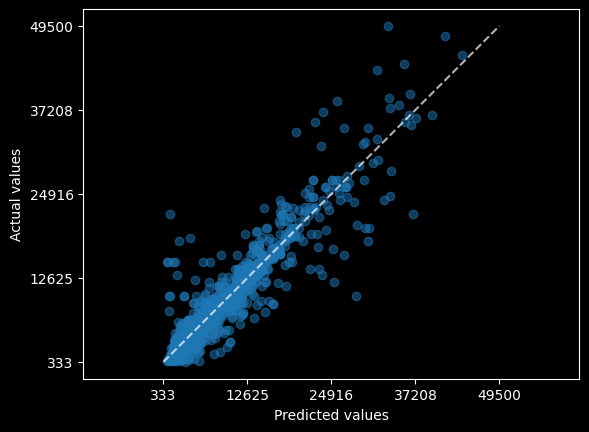

In [ ]:
PredictionErrorDisplay.from_predictions(
    y_val,
    model_hgb.predict(X_val_prep),
    kind="actual_vs_predicted",
    scatter_kwargs={"alpha": 0.5},
        line_kwargs = {"color" : 'white'}

);

Небольшие выводы

* Модель гистограмного градиентного бустинга на этих данных справилась так же как случайный лес с предсказанием целевой переменной (метрика r2 на кросс-валидации `0.86` против `0.86`)

* К сожалению не удается оценить значимость признаков




# Сохранение моделей

In [ ]:
from joblib import dump, load # в scikit-learn ничего такого особенного нет
# пользуемся joblib

In [ ]:
dump(model_ab, 'model_ab.joblib')  # чтобы сохранить объект
dump(model_gb, 'model_gb.joblib')  # чтобы сохранить объект
dump(model_hgb, 'model_hgb.joblib')  # чтобы сохранить объект

['model_hgb.joblib']